In [2]:
import math
import time
import pickle
import pandas as pd
import numpy as np

In [3]:
import torch
import sklearn

In [4]:
from pyqpanda import *

In [5]:
%matplotlib inline

# 1. Prepare Dadaset

In [6]:
# https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

In [7]:
train_path = './../data/DailyDelhiClimateTrain.csv'
test_path = './../data/DailyDelhiClimateTest.csv'

In [8]:
cols = [1,2,3,4]

train = pd.read_csv(train_path, usecols=cols, engine="python")
test = pd.read_csv(test_path, usecols=cols, engine="python")

In [9]:
print(f'len(train)={len(train)}')
print(f'len(test)={len(test)}')

len(train)=1462
len(test)=114


## 1.1 Outlier Detection

### 1.1.1 outlier detection for train

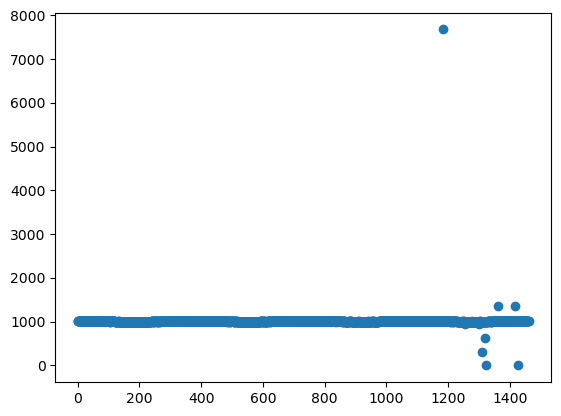

In [10]:
plt.scatter(range(len(train)), train["meanpressure"])

### - remove outliers 

In [11]:
unnormal_num = 0
for i in range(len(train)):
    mp = train.iloc[i][3]
    if mp > 1200 or mp < 950:
        unnormal_num += 1
        train.iloc[i][3] = train.iloc[i + 1][3]
print(f'remove outliers num: {unnormal_num}')

remove outliers num: 9


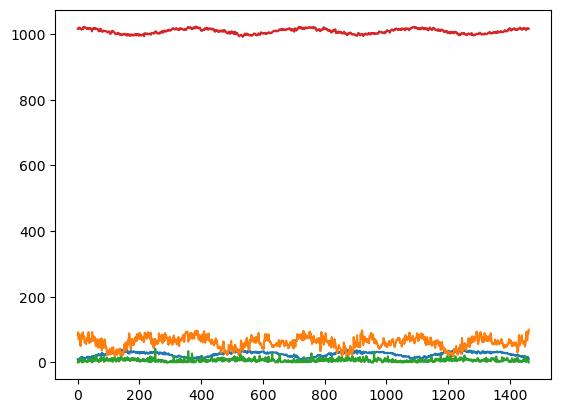

In [12]:
plt.plot(train)

In [13]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1008.247674,7.437992,991.375000,1001.625000,1008.563492,1014.875000,1023.000000


In [14]:
train[0:1]

,meantemp,humidity,wind_speed,meanpressure
0,10.0,84.5,0.0,1015.666667


### 1.1.2 outlier detection for test

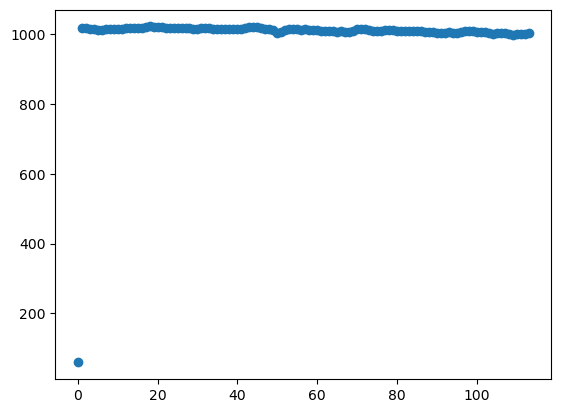

In [15]:
plt.scatter(range(len(test)), test["meanpressure"])

### - remove outliers 

In [16]:
test.iloc[0][3] = test.iloc[1][3]

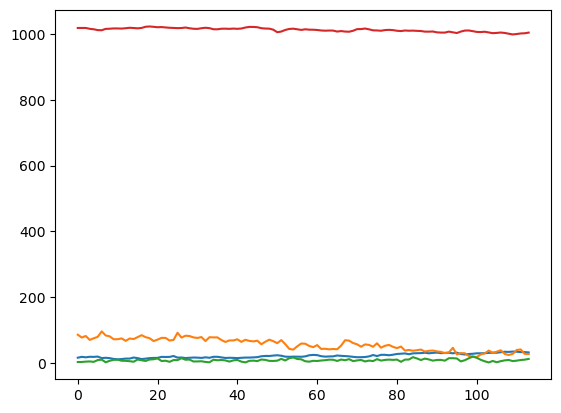

In [17]:
plt.plot(test)

## 1.2 Transfer data to LSTM representation

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
def data_process(data, window_size, predict_size):
    scaler = StandardScaler()
    data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    
    data_in = []
    data_out = []
    
    for i in range(data.shape[0] - window_size - predict_size):
        data_in.append(data[i:i + window_size].reshape(1, window_size)[0])
        data_out.append(data[i + window_size:i + window_size + predict_size].reshape(1, predict_size)[0])
        
    data_in = np.array(data_in).reshape(-1, window_size)
    data_out = np.array(data_out).reshape(-1, predict_size)
    
    data_process = {'datain': data_in, 'dataout': data_out}
    
    return data_process, scaler

## 1.3 prepare train/test dataset

In [20]:
features_size = 4
window_size = features_size * 3 # features num * time steps
predict_size = features_size # features

In [21]:
train_processed, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [22]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

### - data loader

In [23]:
import torch.utils.data as Data

train_data = Data.TensorDataset(X_train, y_train)
test_data = Data.TensorDataset(X_test, y_test)

In [24]:
print(f'size of train_data: {len(train_data)}')
print(f'size of test_data: {len(test_data)}')

size of train_data: 5832
size of test_data: 440


In [25]:
train_data[0]

(tensor([-0.6262, -0.4504, -0.6498,  1.7473, -0.6323, -0.4327, -0.6428,  1.7523,
         -0.6329, -0.4445, -0.6389,  1.7543]),
 tensor([-0.6293, -0.4814, -0.6469,  1.7508]))

In [26]:
test_data[0]

(tensor([-0.6067, -0.4426, -0.6376,  1.7437, -0.6006, -0.4629, -0.6372,  1.7437,
         -0.6039, -0.4520, -0.6346,  1.7438]),
 tensor([-0.6001, -0.4797, -0.6333,  1.7377]))

# 2. Quantum Enhanced LSTM

## 2.1 initiate quantum environment

In [27]:
class InitQMachine:
    def __init__(self, qubitsCount, cbitsCount = 0, machineType = QMachineType.CPU):
        self.machine = init_quantum_machine(machineType)
        
        self.qubits = self.machine.qAlloc_many(qubitsCount)
        self.cbits = self.machine.cAlloc_many(cbitsCount)
        
        print(f'Init Quantum Machine with qubits:[{qubitsCount}] / cbits:[{cbitsCount}] Successfully')
    
    def __del__(self):
        destroy_quantum_machine(self.machine)

In [28]:
# maximum qubits size
ctx = InitQMachine(5)

Init Quantum Machine with qubits:[5] / cbits:[0] Successfully


## 2.2 Quantum Layer

### - Tool Functions

In [29]:
def draw(prog, filename=''):
    dir_path = './images/'
    
    if filename != '':
        draw_qprog(prog, 'pic', filename=f'{dir_path}{filename}')

### 2.2.1 Quantum Layer Base

In [30]:
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter

In [31]:
class QuantumLayerBase(nn.Module):
    def __init__(self, input_size, output_size, *, n_qubits, n_layers = 1, ctx = None):
        super(QuantumLayerBase, self).__init__()
        
        self.data = None # need to input during forward
    
        self.input_size = input_size
        self.output_size = output_size # hidden size, not n_qubits
        
        # quantum infos
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        
        self.ctx = ctx
        self.qubits = ctx.qubits
        self.machine = ctx.machine
        
        # convert quantum input/output to match classical computation
        self.qin = nn.Linear(self.input_size, self.n_qubits)
        self.qout = nn.Linear(self.n_qubits, self.output_size)
        
    @property
    def circuit(self):
        raise NotImplementedError('Should init circuit')

In [32]:
def measure(self):
    HamiZ = [ PauliOperator({f'Z{i}': 1}) for i in range(len(self.qubits)) ]
    res = [ eval(qop(self.circuit, Hami, self.machine, self.qubits))[0,0] for Hami in HamiZ ]
    
    return Parameter(Tensor(res[:self.n_qubits]))

QuantumLayerBase.measure = measure

In [33]:
def forward(self, inputs):
    y_t = self.qin(Parameter(inputs))
    self.data = y_t[0]
    
    return self.qout(self.measure())

QuantumLayerBase.forward = forward

### 2.2.2 Quantum Layer Design

In [34]:
dropout_lock = True

In [35]:
class QuantumLayer(QuantumLayerBase):
    def __init__(self, input_size, output_size, *, n_qubits, degree = 1, n_layers = 1, ctx = None, dropout_rate = 0):
        super(QuantumLayer, self).__init__(input_size, output_size, 
                                         n_qubits = n_qubits, n_layers = n_layers, ctx = ctx)
        
        self.degree = degree
        self.dropout_rate = dropout_rate
        self.angles = Parameter(torch.rand(n_layers + 1, degree, self.n_qubits))
        
    @property
    def qparameters_size(self):
        return self.angles.flatten().size()[0]
        
    @property
    def circuit(self):
        if self.data == None:
            raise ValueError('Need to feed a input data!')
        
        n = self.n_qubits
        q = self.qubits
        x = self.data
        p = self.angles
        degree = self.degree
        
        # quantum gates - must use small case!
        identity = VariationalQuantumGate_I
        h = VariationalQuantumGate_H
        ry = VariationalQuantumGate_RY
        cz = VariationalQuantumGate_CZ
        u = [
            None,
            VariationalQuantumGate_U1,
            VariationalQuantumGate_U2,
            VariationalQuantumGate_U3
        ]
        
        # init variational quantum circuit
        vqc = VariationalQuantumCircuit()

        # in order to use each qubits => when n_qubits < len(ctx.qubits)
        [ vqc.insert(identity(q[i])) for i in range(len(q)) ]
        
        [ vqc.insert( h(q[i]) ) for i in range(n) ]
        [ vqc.insert( ry(q[i], var(x[i] * torch.pi / 2)) ) for i in range(n) ]
        
        for i in range(n):
            for d in range(degree):
                if dropout_lock and np.random.rand() <= self.dropout_rate:
                    p.data[0][d][i] = 0
                
            vqc.insert( u[degree](q[i], *[ var(p[0][d][i]) for d in range(degree) ]) )
        
        for layer in range(self.n_layers):
            for i in range(n - 1):
                vqc.insert(cz(q[i], q[i + 1]))
            vqc.insert(cz(q[n - 1], q[0]))
            
            for i in range(n):
                for d in range(degree):
                    if dropout_lock and np.random.rand() <= self.dropout_rate:
                        p.data[layer + 1][d][i] = 0
                vqc.insert( u[degree](q[i], *[ var(p[layer + 1][d][i]) for d in range(degree) ]) ) 
        
        return vqc

### 2.2.3 Plot Quantum layer

In [36]:
data = Tensor([[0.1, 0.2, 0.3, 0.4, 0.5]])
layer = QuantumLayer(5, 5, n_qubits=5, n_layers=1, degree=3, dropout_rate=0.3, ctx=ctx)
layer.data = data[0]
vqc = layer.circuit
prog = create_empty_qprog()
prog.insert(vqc.feed())

In [37]:
draw_qprog(prog, 'pic', filename=f'pic/angles_yes')

'null'

## 2.3 Quantum-LSTM

In [38]:
class QLSTMBase(nn.Module):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate=0):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.ctx = ctx
        self.dropout_rate = dropout_rate
        
    @property
    def qparameters_size(self):
        num = 0
        for attr in dir(self):
            if attr.endswith('_circuit'):
                num += getattr(self, attr).qparameters_size
        return num

In [39]:
def forward(self, inputs, init_states = None):
    sequence_size, batch_size, _ = inputs.size()
    hidden_sequence = []
    
    if init_states == None:
        h_t, c_t = (
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
        )
    else:
        h_t, c_t = init_states
    
    return hidden_sequence, (h_t, c_t)

QLSTMBase.forward = forward

### 2.3.1 classical Quantum-LSTM

In [40]:
class QLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate=0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # Parameters: angles
        #  => Q * (n + 1) * degree
        
        # gates names:  qubits  layers  degree
        # input gate:     5       2       3
        # forget gate:    5       2       3
        # candidate:      5       2       3
        # output gate:    5       2       3
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(QLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)

            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)

            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        # reshape hidden_seq p/ retornar
        #
        # [tensor([[[0.0444, ...]]] => tensor([[[0.0444, ...]]]
        # 
        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.2 adjusted classical QLSTM

In [41]:
class AdjustedQLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # input gate:     4       2       3
        # forget gate:    5       2       3
        # candidate:      4       1       3
        # output gate:    3       2       2
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 4, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 36
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 24
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 2, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 18
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(AdjustedQLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)

            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)

            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.3 peephole QLSTM

In [42]:
class PeepholeQLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # input gate:     4       2       3
        # forget gate:    5       2       3
        # candidate:      4       1       3
        # output gate:    3       2       2
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 4, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 36
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 24
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 2, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 18
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(PeepholeQLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((c_t[0], x_t), dim = 1)
            
            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)
            
            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.4 Coupled Input and Forget gates QLSTM

In [43]:
class CIFGQLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # coupled IF:     5       2       3
        # candidate:      4       2       3
        # output gate:    3       2       2
        
        # Coupled Input and Forget gate
        self.coupled_IF_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 30
        # candidate for cell state update
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 24
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 2, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 12
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(CIFGQLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)
            
            # coupled input and forget gate
            f_t = torch.sigmoid(self.coupled_IF_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + ((1 - f_t) * g_t)
            
            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.5 Recurrent Gate Units - QGRU

In [44]:
class QGRU(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # update gate:     5       1       3
        # candidate:       4       1       3
        # reset gate:      3       1       2
        
        # update gates
        self.update_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate for hidden state update
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 36
        # reset gates
        self.reset_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 1, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 18
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(QGRU, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)
            
            # update gates
            z_t = torch.sigmoid(self.update_circuit(v_t))
            # reset gates
            r_t = torch.sigmoid(self.reset_circuit(v_t))
        
            v_hat_t = torch.cat(((r_t * h_t)[0], x_t), dim = 1)
            # candidate for hidden state update
            g_t = torch.tanh(self.candidate_circuit(v_hat_t))
            h_t = (z_t * g_t) + (1 - z_t) * h_t 

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### - QLSTMs Map

In [45]:
QLSTMMap = {
    'classical': ('QLSTM', QLSTM),
    'adjusted': ('QLSTM(adjusted)', AdjustedQLSTM),
    'peephole': ('peephole QLSTM', PeepholeQLSTM),
    'CIFG': ('CIFG-QLSTM', CIFGQLSTM),
    'GRU': ('QGRU', QGRU)
}

## 2.4 Stacked QLSTM

In [46]:
from collections import OrderedDict

class StackedQLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, *, num_layers = 1, ctx = None, mode = 'classical', dropout_rate = 0):
        super().__init__()
        
        label, qlstm = QLSTMMap.get(mode)
        self.qlstms = nn.Sequential(OrderedDict([
            (f'{label} {i + 1}', qlstm(input_size if i == 0 else hidden_size , hidden_size, ctx = ctx, dropout_rate = dropout_rate)) 
                for i in range(num_layers)
        ]))

    def forward(self, inputs, parameters = None):
        outputs = None
        
        for i, qlstm in enumerate(self.qlstms):
            if i != 0:
                inputs = outputs
            
            outputs, parameters = qlstm(inputs, parameters)
        
        return outputs, parameters

# 3. Quantum Model and Train

In [47]:
class QModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_output, *, num_layers = 1, ctx = None, mode = 'classical', dropout_rate = 0):
        super(QModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.mode = mode
        
        self.qlstm = StackedQLSTM(input_size, hidden_size, 
                                  num_layers = num_layers, ctx = ctx, mode = mode, dropout_rate = dropout_rate)
        self.predict = nn.Linear(hidden_size, num_output)

    def forward(self, x):
        x = x.unsqueeze(0)
        
        # sequence lenth , batch_size, features length
        # 
        h0 = torch.zeros(1, x.size(1), self.hidden_size)
        c0 = torch.zeros(1, x.size(1), self.hidden_size)
        
        out, _ = self.qlstm(x, (h0, c0))
        out = self.predict(out[0])
        
        return out

## 3.1 train QModel

In [53]:
from torch.utils.data import RandomSampler

def train_model(model, datas, batch_size, *, loss_func, optimizer, epoch = 50, early_stop = False):
    losses = []
    sampler = RandomSampler(datas, num_samples = batch_size)
    
    last_loss = 0.0
    for step in range(epoch):
        train_loss = 0.0
        
        for index in sampler:
            batch_x, batch_y = datas[index][0], datas[index][1]
            b_x = batch_x.unsqueeze(0)
            b_y = batch_y.unsqueeze(0)
            
            output = model(b_x)

            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        loss = train_loss / batch_size
        if early_stop and abs(loss - train_loss) < 1e-4:
            break
            
        last_loss = loss
        
        print(f'Epoch {step + 1}/{epoch}: Loss: {loss}')
        losses.append(loss)
    
    return losses

## 3.2 Evaluate Model

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def MAE_naive(actuals, predicteds):
    n = len(actuals)
    err = 0.0
    
    for i in range(1, n):
        err += np.abs(actuals[i] - actuals[i - 1])
    return err / (n - 1)

def calculate_accuarcy(model, X_test, y_test, scaler=test_scaler):
    n = len(X_test)
    
    actuals = []
    predicteds = []
    
    for i in range(0, n, predict_size):
        actual = scaler.inverse_transform(y_test[i:i+1].data)
        actuals.append(np.array(actual[0]))
        predicted = scaler.inverse_transform(model(X_test[i:i+1]).data)
        predicteds.append(np.array(predicted[0]))
    
    actuals = np.array(actuals)
    predicteds = np.array(predicteds)
    
    mae = mean_absolute_error(actuals, predicteds)
    mase = mae / MAE_naive(actuals.flatten(), predicteds.flatten())
    mape = mean_absolute_percentage_error(actuals, predicteds)
    mse = mean_squared_error(actuals, predicteds)
    rmse = mse ** 0.5
    
    return np.array([(1 - mase) * 100, rmse, mse, mae, mape])

## 3.3 Train Model

In [54]:
features_size = 4
window_size = features_size * 3 # 
predict_size = features_size # features

input_size = window_size
num_output = predict_size

hidden_size = 32
num_layers = 2

In [51]:
# learning rate:
# classical: 0.0035
# adjusted: 0.0028
# peephole: 0.0027
# CIFG: 0.004
# GRU: 0.0035

In [52]:
best_score = 0
best_model = None
count = 1
for dropout_rate in [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05]:
    print('-' * 20)
    print('count:', count)
    print('selected hidden_size: ', hidden_size)
    print('selected num_layers: ', num_layers)
    print('selected dropout_rate: ', dropout_rate)
    count += 1
    dropout_lock = True
    qmodel = QModel(input_size, hidden_size, num_output, 
        num_layers = num_layers, ctx = ctx, mode='adjusted', dropout_rate=dropout_rate)
    optimizer = torch.optim.AdamW(qmodel.parameters(), lr = 0.0028)
    loss_func = nn.MSELoss()

    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 100)
    dropout_lock = False
    score = calculate_accuarcy(qmodel, X_test, y_test).numpy()
    if score > best_score:
        best_score = score
        best_model = qmodel
        best_parameters = {
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'dropout_rate': dropout_rate
        }
    print()

print("Best score: ", best_score)
print("Best parameters: ", best_parameters)

--------------------
count: 1
selected hidden_size:  32
selected num_layers:  2
selected dropout_rate:  0.0001


KeyboardInterrupt: 

In [ ]:
best_score

In [55]:
times = []
accuarcies = []
models = []
mode = 'angles'
for i in range(10):
    print(f'epoch: {i + 1}')
    qmodel = QModel(input_size, hidden_size, num_output, 
                    num_layers = num_layers, ctx = ctx, mode="classical", dropout_rate = 0.001)
    optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.0035)
    loss_func = nn.MSELoss()

    start = time.time()
    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 200)
    end = time.time()

    print(f'time costs: {end - start}')
    times.append(end - start)
    
    accuarcy = calculate_accuarcy(qmodel, X_test, y_test)[0]
    print(f'accuarcy: {accuarcy}')
    accuarcies.append(accuarcy)
    
    with open(f'loss/{mode}/loss_{mode}_{i+1}.pkl', 'wb') as pkl_file:
        pickle.dump(losses, pkl_file)
        
    models.append(qmodel)
    torch.save(qmodel.state_dict(), f"model/{mode}/model_{mode}_{i+1}.pt")

print(f"mean times:{np.mean(times)}")
print(f"mean accuarcy:{np.mean(accuarcies)}")

epoch: 1
Epoch 1/200: Loss: 1.0326350241899491
Epoch 2/200: Loss: 0.9297964811325073
Epoch 3/200: Loss: 0.9325986504554749
Epoch 4/200: Loss: 0.8861274987459182
Epoch 5/200: Loss: 0.8775552332401275
Epoch 6/200: Loss: 0.7984736770391464
Epoch 7/200: Loss: 0.7236734837293625
Epoch 8/200: Loss: 0.632143621519208
Epoch 9/200: Loss: 0.696925880946219
Epoch 10/200: Loss: 0.6033962685614824
Epoch 11/200: Loss: 0.6983004646375776
Epoch 12/200: Loss: 0.5744885351508856
Epoch 13/200: Loss: 0.6393524065613747
Epoch 14/200: Loss: 0.5464672682806849
Epoch 15/200: Loss: 0.6724738266319037
Epoch 16/200: Loss: 0.5416232362389565
Epoch 17/200: Loss: 0.37759777829051017
Epoch 18/200: Loss: 0.313361591566354
Epoch 19/200: Loss: 0.3481754770502448
Epoch 20/200: Loss: 0.23702495326288045
Epoch 21/200: Loss: 0.16408379236236215
Epoch 22/200: Loss: 0.11411468060687184
Epoch 23/200: Loss: 0.074851279030554
Epoch 24/200: Loss: 0.03545596579351695
Epoch 25/200: Loss: 0.03816857549245469
Epoch 26/200: Loss: 0.0

Epoch 196/200: Loss: 0.0006666752757155337
Epoch 197/200: Loss: 0.0007493815319321584
Epoch 198/200: Loss: 0.0005634242435917259
Epoch 199/200: Loss: 0.0008385791450564283
Epoch 200/200: Loss: 0.0009481450069870334
time costs: 1499.4080107212067
accuarcy: 98.7998625187171
epoch: 2
Epoch 1/200: Loss: 1.0450002700090408
Epoch 2/200: Loss: 0.9811436325311661
Epoch 3/200: Loss: 0.9808244377374649
Epoch 4/200: Loss: 0.9157161056995392
Epoch 5/200: Loss: 0.8757891774177551
Epoch 6/200: Loss: 0.7156798079609871
Epoch 7/200: Loss: 0.8926077976822853
Epoch 8/200: Loss: 0.6250160411000252
Epoch 9/200: Loss: 0.5245318464934826
Epoch 10/200: Loss: 0.4831108331680298
Epoch 11/200: Loss: 0.417983490973711
Epoch 12/200: Loss: 0.26162835136055945
Epoch 13/200: Loss: 0.23613086789846421
Epoch 14/200: Loss: 0.13140984158962965
Epoch 15/200: Loss: 0.07427292689681053
Epoch 16/200: Loss: 0.0415279105247464
Epoch 17/200: Loss: 0.015333876758813859
Epoch 18/200: Loss: 0.0042595578968757765
Epoch 19/200: Los

Epoch 189/200: Loss: 0.0006376831610396039
Epoch 190/200: Loss: 0.0007207054724858609
Epoch 191/200: Loss: 0.0005562450191064272
Epoch 192/200: Loss: 0.000763837694103131
Epoch 193/200: Loss: 0.0006576434345333837
Epoch 194/200: Loss: 0.0004787099567693076
Epoch 195/200: Loss: 0.0006678796272353793
Epoch 196/200: Loss: 0.0007524640141127747
Epoch 197/200: Loss: 0.000601085485322983
Epoch 198/200: Loss: 0.0006066223253583303
Epoch 199/200: Loss: 0.0010366124612119164
Epoch 200/200: Loss: 0.0010755552846603677
time costs: 1391.432116508484
accuarcy: 97.55665037799986
epoch: 3
Epoch 1/200: Loss: 0.9711285829544067
Epoch 2/200: Loss: 1.0033724695444106
Epoch 3/200: Loss: 0.9579675376415253
Epoch 4/200: Loss: 0.943780392408371
Epoch 5/200: Loss: 0.8678381085395813
Epoch 6/200: Loss: 0.8888887822628021
Epoch 7/200: Loss: 0.7628397434949875
Epoch 8/200: Loss: 0.7140692219138145
Epoch 9/200: Loss: 0.5750763192772865
Epoch 10/200: Loss: 0.518736620247364
Epoch 11/200: Loss: 0.43128600120544436


Epoch 182/200: Loss: 0.0004606298578437418
Epoch 183/200: Loss: 0.0005900447498788708
Epoch 184/200: Loss: 0.0007317545738260378
Epoch 185/200: Loss: 0.0008220446289669781
Epoch 186/200: Loss: 0.0007445820097927936
Epoch 187/200: Loss: 0.0005138350781635382
Epoch 188/200: Loss: 0.0005135193998285104
Epoch 189/200: Loss: 0.00048110624666151123
Epoch 190/200: Loss: 0.0008558821159567742
Epoch 191/200: Loss: 0.0006967905748751946
Epoch 192/200: Loss: 0.0006417268154109479
Epoch 193/200: Loss: 0.0007139336914406158
Epoch 194/200: Loss: 0.0007835649518710853
Epoch 195/200: Loss: 0.0009163936876575463
Epoch 196/200: Loss: 0.0011520534637384117
Epoch 197/200: Loss: 0.00112099028629018
Epoch 198/200: Loss: 0.0008359444535017246
Epoch 199/200: Loss: 0.0007079619981595897
Epoch 200/200: Loss: 0.001328709558947594
time costs: 1396.945961713791
accuarcy: 97.7350103370031
epoch: 4
Epoch 1/200: Loss: 1.0051317900419234
Epoch 2/200: Loss: 0.9985414415597915
Epoch 3/200: Loss: 0.9704847306013107
Epoch

Epoch 175/200: Loss: 0.0005353501976060216
Epoch 176/200: Loss: 0.0005559881759836571
Epoch 177/200: Loss: 0.0003482542788333376
Epoch 178/200: Loss: 0.0006623328459681943
Epoch 179/200: Loss: 0.00041406910513615004
Epoch 180/200: Loss: 0.0005136764237249735
Epoch 181/200: Loss: 0.0004727544941488304
Epoch 182/200: Loss: 0.0005545823329157429
Epoch 183/200: Loss: 0.0004522704486589646
Epoch 184/200: Loss: 0.0005701808478988824
Epoch 185/200: Loss: 0.0005375615943194134
Epoch 186/200: Loss: 0.0005358155332942261
Epoch 187/200: Loss: 0.0006465780010330491
Epoch 188/200: Loss: 0.0007204514962722896
Epoch 189/200: Loss: 0.0005388877762015909
Epoch 190/200: Loss: 0.0009091096413612832
Epoch 191/200: Loss: 0.000966593790508341
Epoch 192/200: Loss: 0.0005931335836066864
Epoch 193/200: Loss: 0.0005732777099183295
Epoch 194/200: Loss: 0.0005073465657915221
Epoch 195/200: Loss: 0.0005848936103575397
Epoch 196/200: Loss: 0.0008544989490474108
Epoch 197/200: Loss: 0.0006265640964556951
Epoch 198/2

Epoch 168/200: Loss: 0.0005035384619986871
Epoch 169/200: Loss: 0.0004707600441179238
Epoch 170/200: Loss: 0.00048115439094544856
Epoch 171/200: Loss: 0.0006051069567547529
Epoch 172/200: Loss: 0.000428209957863146
Epoch 173/200: Loss: 0.0006997918770139222
Epoch 174/200: Loss: 0.0006614827469093143
Epoch 175/200: Loss: 0.0004550674206257099
Epoch 176/200: Loss: 0.0006732549278240185
Epoch 177/200: Loss: 0.0008037110594159458
Epoch 178/200: Loss: 0.0007863788000577188
Epoch 179/200: Loss: 0.00038094377605375486
Epoch 180/200: Loss: 0.0006726847967911453
Epoch 181/200: Loss: 0.0006680542393951328
Epoch 182/200: Loss: 0.0005217389578319853
Epoch 183/200: Loss: 0.0011990620052529267
Epoch 184/200: Loss: 0.0015624811574525665
Epoch 185/200: Loss: 0.0009439954657864292
Epoch 186/200: Loss: 0.0007474540707335109
Epoch 187/200: Loss: 0.000739319080093992
Epoch 188/200: Loss: 0.000614546891711143
Epoch 189/200: Loss: 0.0007767332464482024
Epoch 190/200: Loss: 0.0006316520761174615
Epoch 191/20

Epoch 161/200: Loss: 0.0005012165157495474
Epoch 162/200: Loss: 0.0005064556342404102
Epoch 163/200: Loss: 0.0003818165550910635
Epoch 164/200: Loss: 0.0005241455701252562
Epoch 165/200: Loss: 0.000769928209047066
Epoch 166/200: Loss: 0.0005546901489651646
Epoch 167/200: Loss: 0.0002994975267938571
Epoch 168/200: Loss: 0.0004713191219707369
Epoch 169/200: Loss: 0.0005876133782294346
Epoch 170/200: Loss: 0.0005920376899211987
Epoch 171/200: Loss: 0.00042883661390078485
Epoch 172/200: Loss: 0.0005811838094359701
Epoch 173/200: Loss: 0.00048528153420193123
Epoch 174/200: Loss: 0.0007784713707224
Epoch 175/200: Loss: 0.0005677784918589168
Epoch 176/200: Loss: 0.0006557933978911023
Epoch 177/200: Loss: 0.0009628211526433005
Epoch 178/200: Loss: 0.000727611191541655
Epoch 179/200: Loss: 0.0008640901123726508
Epoch 180/200: Loss: 0.0006038283581801807
Epoch 181/200: Loss: 0.0009079500596271828
Epoch 182/200: Loss: 0.0010931458265986294
Epoch 183/200: Loss: 0.0007510148070650757
Epoch 184/200:

Epoch 155/200: Loss: 0.0005305807051627198
Epoch 156/200: Loss: 0.0007171596746047726
Epoch 157/200: Loss: 0.0007290454375834087
Epoch 158/200: Loss: 0.0006223681710253004
Epoch 159/200: Loss: 0.0007560063701930631
Epoch 160/200: Loss: 0.0004945785562085802
Epoch 161/200: Loss: 0.0007294627415831201
Epoch 162/200: Loss: 0.000984907847850991
Epoch 163/200: Loss: 0.0005425352675956674
Epoch 164/200: Loss: 0.000577144189082901
Epoch 165/200: Loss: 0.000587145276585943
Epoch 166/200: Loss: 0.0003724960537510924
Epoch 167/200: Loss: 0.0006534886852023192
Epoch 168/200: Loss: 0.0008502691523972316
Epoch 169/200: Loss: 0.0008021287430892698
Epoch 170/200: Loss: 0.0006800699593441095
Epoch 171/200: Loss: 0.0010063692949188407
Epoch 172/200: Loss: 0.0011107483645901085
Epoch 173/200: Loss: 0.000744960402516881
Epoch 174/200: Loss: 0.0008026774370136991
Epoch 175/200: Loss: 0.0008262052195277647
Epoch 176/200: Loss: 0.0009663420845754444
Epoch 177/200: Loss: 0.00045614701994054483
Epoch 178/200:

Epoch 148/200: Loss: 0.000987426019855775
Epoch 149/200: Loss: 0.00084408324873948
Epoch 150/200: Loss: 0.0003095401105383644
Epoch 151/200: Loss: 0.0006040069027221761
Epoch 152/200: Loss: 0.0006687883193080779
Epoch 153/200: Loss: 0.0009591157686372753
Epoch 154/200: Loss: 0.0006372512070811354
Epoch 155/200: Loss: 0.0005811882663692813
Epoch 156/200: Loss: 0.0005064436565589859
Epoch 157/200: Loss: 0.0007572647386950848
Epoch 158/200: Loss: 0.0004808475330719375
Epoch 159/200: Loss: 0.0006168439693283289
Epoch 160/200: Loss: 0.000522893625748111
Epoch 161/200: Loss: 0.00041059337863771363
Epoch 162/200: Loss: 0.0007922630429675337
Epoch 163/200: Loss: 0.0010883009766985197
Epoch 164/200: Loss: 0.0009150283312010288
Epoch 165/200: Loss: 0.0006672451090707909
Epoch 166/200: Loss: 0.0005367869231122313
Epoch 167/200: Loss: 0.0006802782518207096
Epoch 168/200: Loss: 0.0007433961705828551
Epoch 169/200: Loss: 0.0006120456279859355
Epoch 170/200: Loss: 0.000738589842512738
Epoch 171/200: 

Epoch 141/200: Loss: 0.0007250246573221375
Epoch 142/200: Loss: 0.0007389809377855272
Epoch 143/200: Loss: 0.0006896819468238391
Epoch 144/200: Loss: 0.0007692438928643241
Epoch 145/200: Loss: 0.0005511553123142221
Epoch 146/200: Loss: 0.0005400068800554437
Epoch 147/200: Loss: 0.0005139700202562381
Epoch 148/200: Loss: 0.0006074936789900676
Epoch 149/200: Loss: 0.0005649958039612102
Epoch 150/200: Loss: 0.0006719483608321752
Epoch 151/200: Loss: 0.0008232074236730113
Epoch 152/200: Loss: 0.0013830103263899219
Epoch 153/200: Loss: 0.0011441641410783632
Epoch 154/200: Loss: 0.0009859500623861095
Epoch 155/200: Loss: 0.0006239369926333893
Epoch 156/200: Loss: 0.0005793662463474903
Epoch 157/200: Loss: 0.0006523460728203645
Epoch 158/200: Loss: 0.0005969252553768456
Epoch 159/200: Loss: 0.0008241204544901848
Epoch 160/200: Loss: 0.0006632774562604027
Epoch 161/200: Loss: 0.0007740627486782614
Epoch 162/200: Loss: 0.0012009511796350126
Epoch 163/200: Loss: 0.000744705761098885
Epoch 164/20

Epoch 134/200: Loss: 0.0006353067898999143
Epoch 135/200: Loss: 0.0008360990226719877
Epoch 136/200: Loss: 0.0006522555890114745
Epoch 137/200: Loss: 0.001197233152197441
Epoch 138/200: Loss: 0.0007153781207307475
Epoch 139/200: Loss: 0.0015224650014715735
Epoch 140/200: Loss: 0.0007066917831252794
Epoch 141/200: Loss: 0.0008936003579037788
Epoch 142/200: Loss: 0.0009709396234029554
Epoch 143/200: Loss: 0.0008516053676430602
Epoch 144/200: Loss: 0.0010088444861821699
Epoch 145/200: Loss: 0.0010405331497167936
Epoch 146/200: Loss: 0.0007263876283104765
Epoch 147/200: Loss: 0.0010539714430706226
Epoch 148/200: Loss: 0.0007651308293134207
Epoch 149/200: Loss: 0.0006701546576550754
Epoch 150/200: Loss: 0.0005328432304395392
Epoch 151/200: Loss: 0.0006759237272490282
Epoch 152/200: Loss: 0.0005863821976163308
Epoch 153/200: Loss: 0.0005165574138118245
Epoch 154/200: Loss: 0.0006272287970205071
Epoch 155/200: Loss: 0.0009856971280896687
Epoch 156/200: Loss: 0.000660978216183139
Epoch 157/200

In [ ]:
epoch = 10
acc, rmse, mse, mae, mape = 0, 0, 0, 0, 0
for i in range(epoch):
    dropout_lock = True
    qmodel = QModel(input_size, hidden_size, num_output, 
                    num_layers = num_layers, ctx = ctx, mode='classical', dropout_rate = 0.001)
    optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.0015)
    loss_func = nn.MSELoss()

    start = time.time()
    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 200, early_stop=True)
    end = time.time()

    print(f'time costs: {end - start}')

    dropout_lock = False
    results = calculate_accuarcy(qmodel, X_test, y_test)
    acc += results[0]
    rmse += results[1]
    mse += results[2]
    mae += results[3]
    mape += results[4]

    print(results)

print('mean acc: ', acc / epoch)
print('mean rmse: ', rmse / epoch)
print('mean mse: ', mse / epoch)
print('mean mae: ', mae / epoch)
print('mean mape: ', mape / epoch)

In [ ]:
# mean acc:  98.77708771229041
# mean rmse:  8.19976289999141
# mean mse:  68.07838621765883
# mean mae:  6.338886569730907
# mean mape:  0.3011534649602976

In [ ]:
epoch = 10
acc, rmse, mse, mae, mape = 0, 0, 0, 0, 0
for i in range(epoch):
    dropout_lock = True
    qmodel = QModel(input_size, hidden_size, num_output, 
                    num_layers = num_layers, ctx = ctx, mode='classical', dropout_rate = 0.005)
    optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.0015)
    loss_func = nn.MSELoss()

    start = time.time()
    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 200, early_stop=True)
    end = time.time()

    print(f'time costs: {end - start}')

    dropout_lock = False
    results = calculate_accuarcy(qmodel, X_test, y_test)
    acc += results[0]
    rmse += results[1]
    mse += results[2]
    mae += results[3]
    mape += results[4]

    print(results)

print('mean acc: ', acc / epoch)
print('mean rmse: ', rmse / epoch)
print('mean mse: ', mse / epoch)
print('mean mae: ', mae / epoch)
print('mean mape: ', mape / epoch)

In [ ]:
# mean acc:  98.68618230925745
# mean rmse:  8.671875681743698
# mean mse:  76.89663944446423
# mean mae:  6.810088833534145
# mean mape:  0.40398970738091106

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses, color="#FF6666")

In [ ]:
dropout_lock = False
calculate_accuarcy(qmodel, X_test, y_test)

In [ ]:
# array([98.87070045,  7.63037941, 58.22268997,  5.85365099,  0.43295637])

### - save the model

In [ ]:
with open('loss/angle/loss5.pkl', 'wb') as pkl_file:
    pickle.dump(losses, pkl_file)

In [ ]:
average_accuracy = np.mean([
    0.9842, 0.9850, 0.9837, 0.9858, 0.9852
])
average_accuracy

### - describe trained model

In [ ]:
qmodel

In [ ]:
trainable = 0
for p in qmodel.parameters():
    if p.requires_grad:
        trainable += p.numel()
print(f'total parameters: {trainable}')

qlstm = QLSTMMap.get(qmodel.mode)[1]
print(f'quantum paramers: {qlstm(1, 1, ctx = ctx).qparameters_size}')

### - Save the Model

In [ ]:
# save the model
torch.save(qmodel.state_dict(), "model/angle_adjusted.pt")

In [ ]:
results = []

for i in range(0, len(X_test), features_size):
    input_data = X_test[i:i+1]
    result = qmodel(input_data)
    result = test_scaler.inverse_transform(result.data)
    
    results.append(result[0])

test1 = pd.DataFrame(test, columns=('meantemp',))
test2 = pd.DataFrame(test, columns=('humidity',))
test3 = pd.DataFrame(test, columns=('wind_speed',))
test4 = pd.DataFrame(test, columns=('meanpressure',))
results = pd.DataFrame(results)
results.columns = ('meantemp', 'humidity', 'wind_speed', 'meanpressure')
result1 = pd.DataFrame(results, columns=('meantemp', 'humidity', 'wind_speed'))
result2 = pd.DataFrame(results, columns=('meanpressure',))

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.plot(test1, label="meantemp")
plt.plot(test2, label="humidity")
plt.plot(test3, label="wind_speed")

# plt.subplot(1,2,2)
plt.ylim(0, 100)
plt.plot(result1, color="#FF6666", linestyle="--")
plt.legend()

# plt.subplot(1,2,1)
plt.subplot(1,2,2)
plt.plot(test4, label="meanpressure", color="#9966CC")
plt.ylim(980, 1050)
plt.plot(result2, color="#FF6666", linestyle='--')

plt.legend()